# Matterport model for prediction

- Only binary predictions

In [2]:
# Inputs
randomShuffle = True
nPCA = 5
# True: training and test sets determined from random shuffle
# False: test sets contain none of the same qIds as the training set
import pandas as pd
import numpy as np
#feature_set = ['qType','objName','objIndex','totalSteps','temporalExposure','objArea'];
feature_set = ['qType','totalSteps','exposureStep','temporalExposure','objArea',];
for i in np.arange(nPCA):
    feature_set.append('PCA'+str(i))
    
predictor = 'requestedAssist'#'requestedAssist'
dataset = pd.read_csv('questionFeaturesMod.csv')
dataset = dataset.dropna();
dataset.head()

,qsetId,qId,qType,objName,objIndex,totalSteps,exposureStep,temporalExposure,spatialExposureRatio,objArea,totalArea,requestedAssist,answeredCorrect,navigated,classY
0,2545,3889,color_room,sofa,33,31,4,3,0.003293,33873,10285056,True,True,True,5
1,2545,3871,exist_positive,cushion,24,31,31,1,0.032258,331776,10285056,True,True,True,5
2,2545,3872,exist_positive,stool,12,31,31,1,0.032258,331776,10285056,False,False,False,0
3,2717,1051,location,fireplace,26,29,13,6,0.000322,3099,9621504,True,False,True,2
4,2717,1087,color_room,dishwasher,30,29,19,5,0.000169,1629,9621504,False,True,False,3


In [3]:
dataset.qType.unique().size

5

In [4]:
# put unique objects in a list
sentences = list()
uniqueObjects = dataset.objName.unique();
from collections import OrderedDict
uniqueObjectsDict = OrderedDict()
for i in np.arange(len(uniqueObjects)):
    sentences.append([uniqueObjects[i]]);
    uniqueObjectsDict[uniqueObjects[i]] = i;

In [5]:
len(uniqueObjectsDict)

35

In [6]:
# Get glove working
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
#glove_input_file = 'matterport/glove.6B.50d.txt'
word2vec_output_file = 'matterport/test_word2vec.txt'
#glove2word2vec(glove_input_file, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file)

ModuleNotFoundError: No module named 'gensim'

In [7]:
# Project object names into 50-dimensional embedding space
word_vectors = model.wv
embeddings = np.ndarray(shape =(len(uniqueObjects),50))
for i in np.arange(len(uniqueObjects)):
    embeddings[i,:] = word_vectors.word_vec(uniqueObjects[i])

NameError: name 'model' is not defined

In [8]:
# Apply PCA to reduce dimensionalitiy of encoding
from sklearn.decomposition import PCA
from matplotlib import pyplot
pca = PCA(n_components=nPCA)
result = pca.fit_transform(embeddings)
# create a scatter plot of the projection
pyplot.figure(figsize=(20,20))
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(uniqueObjects):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]),fontsize=24)
pyplot.show()

ModuleNotFoundError: No module named 'sklearn'

In [8]:
# insert columns for principal components into dataset
embeddingMat = np.ndarray(shape =(nPCA,len(dataset)))
for j in np.arange(len(dataset)):
    embeddingMat[:,j] = np.transpose(result[uniqueObjectsDict[dataset.objName.values[j]],:])
for i in np.arange(nPCA):
    dataset.insert(len(dataset.columns),"PCA"+str(i),embeddingMat[i,:])

In [9]:
# Add column for one of three outcomes
outcome = []
outcomeBin0 = []
outcomeBin1 = []
outcomeBin2 = []

for i in np.arange(len(dataset)):
    if (dataset.loc[i,"classY"] in [0,3]):
        outcome.append(0)
        outcomeBin0.append(1)
        outcomeBin1.append(0)
        outcomeBin2.append(0)
    elif (dataset.loc[i,"classY"] in [1,4]):
        outcome.append(1)
        outcomeBin0.append(0)
        outcomeBin1.append(1)
        outcomeBin2.append(0)
    elif (dataset.loc[i,"classY"] in [2,5]):
        outcome.append(2)
        outcomeBin0.append(0)
        outcomeBin1.append(0)
        outcomeBin2.append(1)
dataset.insert(len(dataset.columns),"behavior",outcome)
dataset.insert(len(dataset.columns),"outcomeBin0",outcomeBin0)
dataset.insert(len(dataset.columns),"outcomeBin1",outcomeBin1)
dataset.insert(len(dataset.columns),"outcomeBin2",outcomeBin2)

In [10]:
# Convert qTye and objName to categorical variables if needed
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
dataset['qType'] = le.fit_transform(dataset.qType.values)
dataset['objName'] = le.fit_transform(dataset.objName.values)

In [11]:
testFrac = 0.2
if randomShuffle: 
    from sklearn.model_selection import train_test_split
    X = dataset[feature_set].values
    y = dataset[[predictor]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFrac, random_state=0)
else:
    sorted_dataset = dataset.sort_values(by=['qId'])
    testNum = int(np.floor(len(dataset)*0.2))
    trainingNum = len(dataset) - testNum
    X_train = sorted_dataset[feature_set].values[:trainingNum]
    y_train = sorted_dataset[[predictor]].values[:trainingNum]
    X_test = sorted_dataset[feature_set].values[trainingNum:]
    y_test = sorted_dataset[[predictor]].values[trainingNum:]

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

names = ["RF","MLP","SVM"]
classifiers = [RandomForestClassifier(),MLPClassifier(hidden_layer_sizes=(50,3)),SVC(gamma=2, C=1,probability=True)]
icounter = 0
score = []
y_pred = np.ndarray(shape=(X_test.shape[0],len(names)))
Y_score = np.ndarray(shape=(X_test.shape[0],len(names)))
for name, clf in zip(names, classifiers):
    clf.fit(X_train,y_train)
    score.append(clf.score(X_test,y_test))
    y_pred[:,icounter] = clf.predict(X_test)
    print(name)
    print(score)
    print(classification_report(y_test,y_pred[:,icounter]))
    Y_score[:,icounter] = clf.predict_proba(X_test)[:,1]
    print(roc_auc_score(y_test, Y_score[:,icounter]))
    icounter = icounter + 1

/mnt/xarfuse/uid-203237/e83add24-ns-4026531840/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RF
[0.663280662151994]
              precision    recall  f1-score   support

       False       0.74      0.83      0.78      1915
        True       0.35      0.23      0.28       743

   micro avg       0.66      0.66      0.66      2658
   macro avg       0.54      0.53      0.53      2658
weighted avg       0.63      0.66      0.64      2658

0.585396160509402
MLP
[0.663280662151994, 0.7121896162528216]
              precision    recall  f1-score   support

       False       0.72      0.97      0.83      1915
        True       0.35      0.03      0.06       743

   micro avg       0.71      0.71      0.71      2658
   macro avg       0.54      0.50      0.45      2658
weighted avg       0.62      0.71      0.62      2658

0.5990490882703317
SVM
[0.663280662151994, 0.7121896162528216, 0.7118133935289691]
              precision    recall  f1-score   support

       False       0.73      0.94      0.83      1915
        True       0.44      0.12      0.18       743

   micro avg  

In [14]:
print(np.sum(dataset['classY']==3)/(np.sum(dataset['classY']==0) + np.sum(dataset['classY']==3)))
print(np.sum(dataset['classY']==4)/(np.sum(dataset['classY']==1) + np.sum(dataset['classY']==4)))
print(np.sum(dataset['classY']==5)/(np.sum(dataset['classY']==2) + np.sum(dataset['classY']==5)))

0.772683858643744
0.6737556561085973
0.7969738651994498


[0.05661662 0.21414947 0.20419934 0.11174649 0.20537961 0.05276197
 0.04099888 0.03288121 0.04380062 0.03746579]


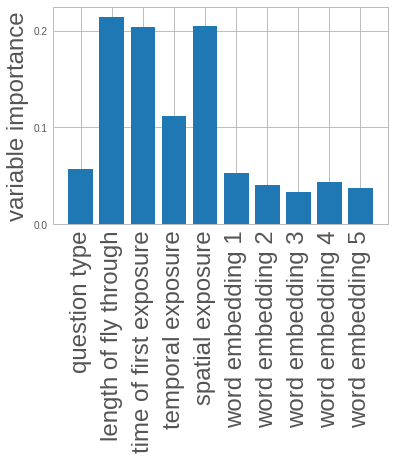

In [15]:
import matplotlib.pyplot as plt
importances = classifiers[0].feature_importances_
print(importances)
ypos = np.arange(len(feature_set))
plt.bar(ypos,importances)
plt.ylabel('variable importance')
feature_set_names = ["question type","length of fly through","time of first exposure","temporal exposure","spatial exposure","word embedding 1","word embedding 2","word embedding 3","word embedding 4","word embedding 5"]

plt.xticks(ypos,feature_set_names,rotation='vertical',fontsize=24 )

plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.ylabel('variable importance',fontsize=24)
plt.show()

0.663280662151994
0.7121896162528216
0.7118133935289691


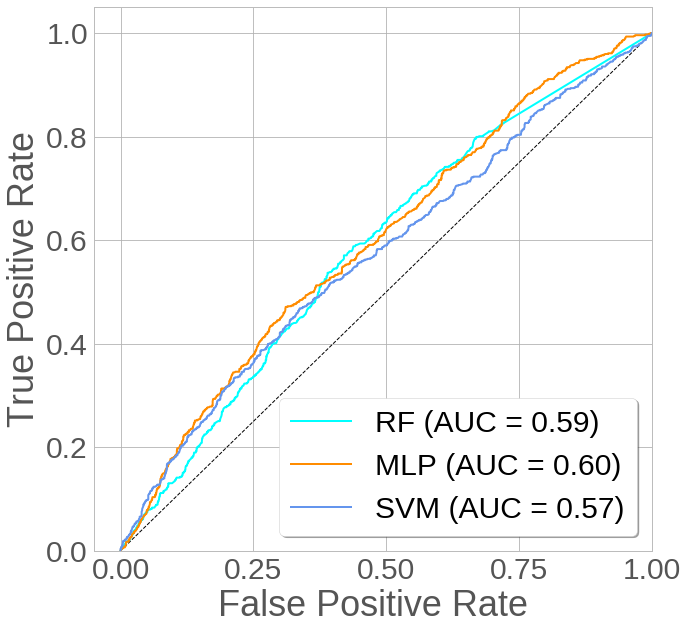

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import numpy as np

from itertools import cycle
lw=2

names = ["RF","MLP","SVM"]

fpr = []
tpr = []
roc_auc = []

for i in np.arange(3):
    acc = classifiers[i].score(X_test,y_test)
    print(acc)
    roc_auctmp = dict()
    fprtmp, tprtmp, _ = roc_curve(y_test, Y_score[:,i])
    roc_auctmp = auc(fprtmp, tprtmp)
    fpr.append(fprtmp)
    tpr.append(tprtmp)
    roc_auc.append(roc_auctmp)
    
    # make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=36)
plt.ylabel('True Positive Rate',fontsize=36)
plt.grid(True)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (AUC = {1:0.2f})'
             ''.format(names[i], roc_auc[i]))


plt.rc('xtick',labelsize=36)
plt.rc('ytick',labelsize=36)
plt.legend(loc="lower right", shadow=True, fancybox =True,fontsize=30) 
plt.show()